<a href="https://colab.research.google.com/github/IvanDePivan/2AMM30-groep-2-component-1/blob/main/Undersample_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import json
import numpy as np
import spacy
from spacy.training.example import Example #holds information for one training instance
import random
from tqdm import tqdm
from spacy.scorer import Scorer
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:0

In [2]:
# Authenticate
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

# Get email of current Colab user
import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
email = gcloud_tokeninfo['email']

Mounted at /content/drive


In [3]:
# Define filepath
if email == 'tamaraexterkate93@gmail.com':
  filename = "/content/drive/MyDrive/TUe/TM/Exports/export_component_1.json"
elif email == 'n.v.diermen@student.tue.nl':
  filename = "/content/drive/MyDrive/Text Mining/train_data.json"

In [4]:
DATA = []

# read json file
with open(filename, 'rb') as fp:
  training_data = json.load(fp)

  # get text, labels, relations, benchmark for each article
  for article in training_data:
    entities = []
    id_entities = []
    relations = []
    original_text = article.get('data').get('text')
    if len(article.get('annotations')) == 5: # N=5
      benchmark = True
    else:
      benchmark = False
    for annotation in article.get('annotations'):
      if annotation.get('ground_truth') == True: # only include ground truth
        for ind, label in enumerate(annotation.get('result')):
          if label.get('type') == 'labels':
            start = label.get('value').get('start')
            end = label.get('value').get('end')
            id = label.get('id')
            text = label.get('value').get('text')
            label = label.get('value').get('labels')[0] # note: cannot deal with multiple labels
            id_entities.append((start, end, label, id, text)) # WHY ORDER WEIRD FOR TRAIN[0]?
            entities.append((start, end, label))
          elif label.get('type') == 'relation':
            from_id = label.get('from_id')
            to_id = label.get('to_id')
            relation = label.get('labels')[0] # note: cannot deal with multiple relations
            if relation != "same_as":
              relations.append((from_id, to_id, relation))
          else:
            print("found unknown label type (no label or relation)")

    # append article to training data as dictionary
    DATA.append({
    'text': original_text,
    'entities': entities,
    'id_entities': id_entities,
    'relations': relations,
    'benchmark': benchmark
    })

In [5]:
# Remove entities with smallest span in case of overlapping entities
def remove_overlap(entities):
  # Initialize a list to store the final non-overlapping entities
  final_entities = []

  # Sort the entities by their start position in ascending order
  entities.sort(key=lambda entity: entity[0])

  # Iterate through the sorted entities
  for entity in entities:
      overlaps = False
      for existing_entity in final_entities:
          # Check for overlapping entities
          if (entity[0] >= existing_entity[0] and entity[0] < existing_entity[1]) or \
            (entity[1] > existing_entity[0] and entity[1] <= existing_entity[1]):
              overlaps = True
              break
      if not overlaps:
          final_entities.append(entity)

  return final_entities

for article in DATA:
  article['entities'] = remove_overlap(article['entities'])

In [6]:
def get_distances(DATA):
  # get maximum distances between entities per relation type
  all_distances = {}
  for data in DATA:
    for relation in data['relations']:
      rel_from_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[0]]
      rel_to_begin = [entity[0] for entity in data['id_entities'] if entity[3] == relation[1]]
      distance = abs(rel_from_begin[0] - rel_to_begin[0])

      if all_distances.get(relation[2]) == None:
        all_distances[relation[2]] = distance
      else:
        all_distances[relation[2]] = max(all_distances[relation[2]], distance)

  return all_distances

In [8]:
def train_test_split(data, val_size):

  print(f'Total articles: {len(data)}')
  train_end = int(len(data)*(1-val_size))
  train = data[0:train_end]
  val = data[train_end:len(data)]

  print(f'Size train: {len(train)}')
  print(f'Size val: {len(val)}')

  return train, val

In [9]:
 train, val =  train_test_split(DATA, val_size=0.25)


Total articles: 102
Size train: 76
Size val: 26


In [ ]:
def insert_markers(text, pair):

  label_to_marker = {
      'Winner': '[WINR]',
      'Date': '[DATE]',
      'Prizetype': '[PRZT]',
      'Reason': '[REAS]',
      'Nationality': '[NTLY]'
  }

  start_to_add = 0
  end_to_add = 7
  for ent in pair:
    start = ent[0]
    end = ent[1]
    label = ent[2]
    start += start_to_add
    end += end_to_add
    text = text[:start] + label_to_marker[label] + ' ' + text[start:]
    text = text[:end] +' '+ label_to_marker[label] + text[end:]
    start_to_add += 7*2
    end_to_add += 7*2

  return text

In [10]:
def get_relation(pair, relations):
  if pair[0][3] and pair[1][3]: # check if entities of pair exist in annotations
    # see if and what relation there is between the entities of the pair
    for relation in relations:
      if (relation[0] == pair[0][3] and relation[1] == pair[1][3]) or (relation[1] == pair[0][3] and relation[0] == pair[1][3]):
          return relation[2]
  return 'no_relation'

In [13]:
def mark_data(data, NER_output=False, prune = None):

  # init data output and relations list
  data_output = []
  relations_output = []

  # Iterate over each article in data
  for article in data:

    # get original text and convert to doc
    text = article['text']

    # get seperate list of winner entities and other entities in fixed format (start,end,label,id)
    if NER_output:
      # create doc
      doc = best_nlp(text)

      pers_comp = []
      time_date = []
      for ent in doc.ents:
        # check to what entity in the annotations the NER entity refers to
        for original_ent in article['id_entities']:
          ent_id = None # refer to None if entity is not in annotations
          # otherwise overwrite with id of entity in annotations
          if ent.start_char == original_ent[0] and ent.end_char == original_ent[1]:
            ent_id = original_ent[3]
            break
        if ent.label_=='Person intervention/event' or ent.label_=='Component event/state':
          pers_comp.append((ent.start_char, ent.end_char, ent.label_, ent_id))
        else:
          time_date.append((ent.start_char, ent.end_char, ent.label_, ent_id))

    else:
      ents = article['id_entities']
      pers_comp = [ent for ent in ents if ent[2]=='Person intervention/event' or ent[2]=='Component event/state']
      time_date = [ent for ent in ents if ent[2] =='Time' or ent[2] =='Date']

    # make pairs for possible relations (pers_com + pers_com/other)
    pairs = []

    for ent1 in pers_comp:
      for ent2 in pers_comp:
        if ent1[3] != ent2[3]:
          pairs.append((ent1,ent2))
          pairs.append((ent2,ent1))
      for ent2 in time_date:
        pairs.append((ent1,ent2))

    # create new text with markers for each possible relation with winner
    relations_output.extend([get_relation(pair, article['relations']) for pair in pairs])

  return np.array(relations_output)

In [ ]:
def check_contains_relation(tokens, marker_tokens):
  """Return True if piece of text (tokens) contains a possible relation (= 4 marker tokens)."""

  marker_token_counts = {marker_token: tokens.count(marker_token) for marker_token in marker_tokens}
  nr_marker_tokens = sum(marker_token_counts.values())
  return nr_marker_tokens == 4

def split_paragraphs(X_data, y_data):

  # init
  X_result = []
  y_result = []

  for x, y in zip(X_data, y_data):
    for paragraph in x.split('\n'):
      contains_markers = check_contains_relation(paragraph, special_tokens)
      if contains_markers:
        X_result.append(paragraph)
        y_result.append(y)

  return np.array(X_result), np.array(y_result)

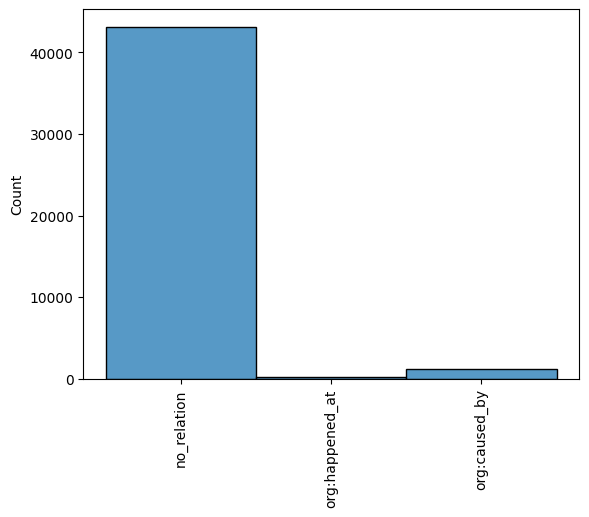

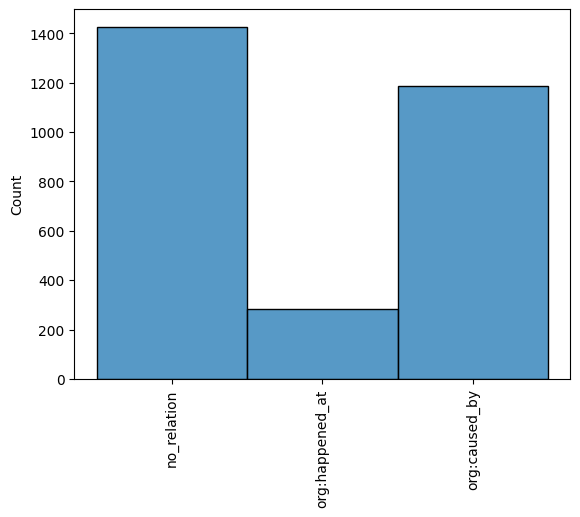

In [18]:
y_train = mark_data(train, NER_output=False)
y_val = mark_data(val, NER_output=False)

# X_train, y_train = split_paragraphs(X_train, y_train)
# X_val, y_val = split_paragraphs(X_val, y_val)
# X_test, y_test = split_paragraphs(X_test, y_test)


sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()

def desample(y,sample_factor = 1.8):
  # get second highest category
  label_counts = Counter(y)
  relation_counts = label_counts.copy()
  relation_counts.pop('no_relation')
  n_samples = round(sample_factor * max(relation_counts.values())) # allow slight class imbalance for no_relation

  # if no_relation imbalanced, randomly downsample these relations
  if label_counts['no_relation'] - n_samples > 0:
    desample_mask = y != 'no_relation'
    ind_no_relation = np.where(y == 'no_relation')[0]
    include_no_relations = (np.random.choice(ind_no_relation,n_samples, replace = False))
    desample_mask[include_no_relations] = 1
  y = y[desample_mask]

  return y

# randomly undersample no_relation in train
y_train = desample(y_train, sample_factor =1.2)

sns.histplot(y_train)
plt.xticks(rotation=90)
plt.show()